In [11]:
! pip install monai

     ---------------------------------------- 1.3/1.3 MB 10.6 MB/s eta 0:00:00


In [1]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import numpy as np
import tensorflow as tf
import nibabel as nib
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize

import argparse
import logging
import os
import random
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tensorboardX import SummaryWriter
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms

import zipfile
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from copy import deepcopy

from nilearn import plotting

import torch.nn.functional as F

import monai
from monai.transforms import Rand3DElasticd

In [37]:
# UNZIP THE LABEL DATA

from tqdm import tqdm
import os
import zipfile

label_dir = 'datasets/ULS23_Radboudumc_Bone/labels'

# Loop through the image files
for filename in tqdm(os.listdir(label_dir)):
    if filename.endswith('.nii.gz.zip'):
        file_path = os.path.join(label_dir, filename)
        # Open the zip file
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            # Extract all the contents into the same directory
            zip_ref.extractall(label_dir)
        os.remove(file_path)

print("Unzipping done.")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 697/697 [00:06<00:00, 115.13it/s]

Unzipping done.


In [44]:
datasets_dir = 'datasets'

files = {}
for subfolder in os.listdir(datasets_dir):
    subfolder_path = os.path.join(datasets_dir, subfolder)
    if os.path.isdir(subfolder_path) and 'images' in os.listdir(subfolder_path) and 'labels' in os.listdir(subfolder_path):
        labels_path = os.path.join(subfolder_path, 'labels')
        files[subfolder] = [file[:-7] for file in os.listdir(labels_path)]
        
# for subfolder, filenames in files.items():
#     for filename in filenames:
#         label_path = os.path.join(datasets_dir, subfolder, 'images', filename + '.nii.gz')
#         if not os.path.isfile(label_path):
#             print(label_path)

In [45]:
def split_list(data, train_prop=0.6, val_prop=0.2, test_prop=0.2):
    if train_prop + val_prop + test_prop != 1:
        raise ValueError("The proportions must sum up to 1.")
    
    random.shuffle(data)
    
    # Calculate split indices
    total_len = len(data)
    train_end = int(total_len * train_prop)
    val_end = train_end + int(total_len * val_prop)
    
    # Split the data
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    
    return train_data, val_data, test_data


train_data, val_data, test_data = {}, {}, {}
for subfolder, filenames in files.items():
    train, val, test = split_list(filenames)
    train_data[subfolder] = train
    val_data[subfolder] = val
    test_data[subfolder] = test
    
def save_dict(data, output_dir, filename):
    file_path = os.path.join(output_dir, filename)
    with open(file_path, 'w') as file:
        for subfolder, filenames in data.items():
            for filename in filenames:
                file.write(f"{subfolder} {filename}\n")
      
output_dir = 'datasets'
save_dict(train_data, output_dir, "all_train.txt")
save_dict(val_data, output_dir, "all_val.txt")
save_dict(test_data, output_dir, "all_test.txt")

In [36]:
class All_dataset(Dataset):
    """
    Assumes that labels are already unzipped
    """

    def __init__(self, datasets_dir, list_dir, split, clip=-1, transform=None):
        self.transform = transform
        self.split = split
        self.sample_list = [
            line.strip("\n").split(" ")
            for line in open(
                os.path.join(list_dir, "all_" + self.split + ".txt")
            )
        ]
        if clip > 0:
            self.sample_list = self.sample_list[:clip]
        self.datasets_dir = datasets_dir

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        subfolder, filename = self.sample_list[idx][0], self.sample_list[idx][1]
        image_path = os.path.join(self.datasets_dir, subfolder, 'images', filename + ".nii.gz")
        label_path = os.path.join(self.datasets_dir, subfolder, 'labels', filename + ".nii.gz")
        image = nib.load(image_path).get_fdata()
        label = nib.load(label_path).get_fdata()
        image = np.expand_dims(np.moveaxis(np.squeeze(image), 2, 0), axis=0)
        label = np.expand_dims(np.moveaxis(np.squeeze(label), 2, 0), axis=0)
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        sample = {"image": image, "label": label}
        if self.transform:
            sample = self.transform(sample)
        sample["case_name"] = filename
        return sample
   

list_dir = 'datasets'

transform = Rand3DElasticd(
    keys=["image", "label"],
    sigma_range=(5, 8),
    magnitude_range=(50, 100),
    prob=0.5,
    translate_range=5,
    rotate_range=np.pi / 12,
    scale_range=(0.1, 0.1, 0.1),
    padding_mode="border",
)

db_train = All_dataset(
    datasets_dir, list_dir, "train", transform=transform
)
db_val = All_dataset(datasets_dir, list_dir, "val", transform=transform)
db_test = All_dataset(
    datasets_dir, list_dir, "test", transform=transform
)
print("The length of train set is: {}".format(len(db_train)))
print("The length of val set is: {}".format(len(db_val)))
print("The length of test set is: {}".format(len(db_test)))

trainloader = DataLoader(db_train, batch_size=1, shuffle=True)
valloader = DataLoader(db_val, batch_size=1, shuffle=True)

The length of train set is: 970
The length of val set is: 322
The length of test set is: 326


In [32]:
# Test to see if loader is correct
i_batch, sampled_batch = next(enumerate(trainloader))
image_batch, label_batch = sampled_batch['image'], sampled_batch['label']
print(i_batch)
print(image_batch.shape)
print(label_batch.shape)

0
torch.Size([1, 1, 128, 256, 256])
torch.Size([1, 1, 128, 256, 256])


In [2]:
parent_dir = 'datasets/ULS23_DeepLesion3D/categories'

def list_files_in_subfolders(directory):
    subfolders_files = {}
    for entry in os.listdir(directory):
        subfolder_path = os.path.join(directory, entry)
        if os.path.isdir(subfolder_path):
            subfolders_files[entry] = [file[:-4] for file in os.listdir(subfolder_path)]
    return subfolders_files

files = list_files_in_subfolders(parent_dir)

In [3]:
def split_list(data, train_prop=0.6, val_prop=0.2, test_prop=0.2):
    if train_prop + val_prop + test_prop != 1:
        raise ValueError("The proportions must sum up to 1.")
    
    random.shuffle(data)
    
    # Calculate split indices
    total_len = len(data)
    train_end = int(total_len * train_prop)
    val_end = train_end + int(total_len * val_prop)
    
    # Split the data
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    
    return train_data, val_data, test_data

train_data, val_data, test_data = [], [], []
for subfolder, filenames in files.items():
    train, val, test = split_list(filenames)
    train_data.extend(train)
    val_data.append(val)
    test_data.append(test)
    
    
def save_list(data, output_dir, filename):
    file_path = os.path.join(output_dir, filename)
    with open(file_path, 'w') as file:
        for item in data:
            file.write(f"{item}\n")
      
output_dir = 'datasets'
save_list(train_data, output_dir, "deeplesion_train.txt")
save_list(val_data, output_dir, "deeplesion_val.txt")
save_list(test_data, output_dir, "deeplesion_test.txt")

In [4]:
class Encoding3D(nn.Module):
    def __init__(self, D, K, encoding):
        super(Encoding3D, self).__init__()
        self.D, self.K = D, K
        self.codewords = nn.Parameter(torch.Tensor(K, D), requires_grad=True)
        self.scale = nn.Parameter(torch.Tensor(K, D), requires_grad=True)
        self.reset_params()
        self.encoding = encoding

        self.fc = nn.Sequential(
            nn.Linear(D, D),
            nn.Sigmoid())

    def reset_params(self):
        std1 = 1./((self.K*self.D)**(1/2))
        self.codewords.data.uniform_(-std1, std1)
        self.scale.data.uniform_(-1, 0)

    def forward(self, X):
        assert(X.size(1) == self.D)
        B, D, T, H, W = X.size()
        N = T * H * W
        K = self.K

        # Flatten X to (B, N, D) for processing
        I = X.view(B, D, N).transpose(1, 2).contiguous()

        # Calculate assignment weights A (B, N, K, D)
        A = F.softmax(self.scale.view(1, 1, K, D) * (I.unsqueeze(2) - self.codewords.view(1, K, D)).pow(2), dim=2)

        if not self.encoding:  # Embedding
            E = (A * (I.unsqueeze(2) - self.codewords.view(1, K, D))).sum(1)
            E = E.mean(dim=1)
            gamma = self.fc(E)

            E = (A * (I.unsqueeze(2) - self.codewords.view(1, K, D))).sum(2)
            E = E.transpose(1, 2).contiguous().view(B, D, T, H, W)
            y = gamma.view(B, D, 1, 1, 1)
            E = F.relu_(E + E * y)
        else:  # Encoding
            E = (A * (I.unsqueeze(2) - self.codewords.view(1, K, D))).sum(1)

        return E

class EmbeddingModule3D(nn.Module):
    def __init__(self, in_channels, ncodes=24):
        super(EmbeddingModule3D, self).__init__()
        self.encoding = nn.Sequential(
            nn.Conv3d(in_channels, in_channels, 1, bias=False),
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True),
            Encoding3D(D=in_channels, K=ncodes, encoding=False),
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True))
        self.conv = nn.Sequential(
            nn.Conv3d(2 * in_channels, in_channels, 1, bias=True),
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        encoded = self.encoding(x)
        output = self.conv(torch.cat((x, encoded), dim=1))
        return output

class ResBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.downsample = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm3d(out_channels)
        ) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            residual = self.downsample(residual)
        out += residual
        out = self.relu(out)
        return out
    
class UNet3DWithKEM(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_n_filter=64):
        super(UNet3DWithKEM, self).__init__()

        self.enc1 = ResBlock3D(in_channels, base_n_filter)
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = ResBlock3D(base_n_filter, base_n_filter * 2)
        self.pool2 = nn.MaxPool3d(2)

        self.enc3 = ResBlock3D(base_n_filter * 2, base_n_filter * 4)
        self.pool3 = nn.MaxPool3d(2)

        # Bottleneck with KEM
        self.bottleneck = ResBlock3D(base_n_filter * 4, base_n_filter * 8)
        self.kem = EmbeddingModule3D(base_n_filter * 8)

        self.up3 = nn.ConvTranspose3d(base_n_filter * 8, base_n_filter * 4, kernel_size=2, stride=2)
        self.dec3 = ResBlock3D(base_n_filter * 8, base_n_filter * 4)

        self.up2 = nn.ConvTranspose3d(base_n_filter * 4, base_n_filter * 2, kernel_size=2, stride=2)
        self.dec2 = ResBlock3D(base_n_filter * 4, base_n_filter * 2)

        self.up1 = nn.ConvTranspose3d(base_n_filter * 2, base_n_filter, kernel_size=2, stride=2)
        self.dec1 = ResBlock3D(base_n_filter * 2, base_n_filter)

        self.final_conv = nn.Conv3d(base_n_filter, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        pool1 = self.pool1(enc1)

        enc2 = self.enc2(pool1)
        pool2 = self.pool2(enc2)

        enc3 = self.enc3(pool2)
        pool3 = self.pool3(enc3)

        bottleneck = self.bottleneck(pool3)
        kem_output = self.kem(bottleneck)

        up3 = self.up3(kem_output)
        dec3 = self.dec3(torch.cat((up3, enc3), dim=1))

        up2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat((up2, enc2), dim=1))

        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat((up1, enc1), dim=1))

        output = self.final_conv(dec1)
        return output

In [5]:
model = UNet3DWithKEM(base_n_filter=16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))

model = nn.DataParallel(model)
model.to(device)

Using device cuda
NVIDIA GeForce RTX 3070 Ti Laptop GPU


DataParallel(
  (module): UNet3DWithKEM(
    (enc1): ResBlock3D(
      (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc2): ResBlock3D(
      (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# CREATE A TORCH DATASET

from torch.utils.data import Dataset
import os
import nibabel as nib
import torch

class DeepLesion_dataset(Dataset):
    '''
    Assumes that labels are already unzipped
    '''
    def __init__(self, image_dir, label_dir, list_dir, split, clip=-1, transform=None):
        self.transform = transform
        self.split = split
        self.sample_list = [line.strip('\n') for line in open(os.path.join(list_dir, 'deeplesion_'+self.split+'.txt'))]
        self.image_dir = image_dir
        self.label_dir = label_dir

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        filename = self.sample_list[idx]
        image_path = os.path.join(self.image_dir, filename+'_lesion_01.nii.gz')
        label_path = os.path.join(self.label_dir, filename+'_lesion_01.nii.gz')
        image = nib.load(image_path).get_fdata()
        label = nib.load(label_path).get_fdata()
        image = np.expand_dims(np.squeeze(image), axis=0)
        label = np.expand_dims(np.squeeze(label), axis=0)
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        
        sample = {'image':image, 'label':label}
        if self.transform:
            sample = self.transform(sample)
        sample['case_name'] = filename
        return sample
    

image_dir = 'datasets/ULS23_DeepLesion3D/images'
label_dir = 'datasets/ULS23_DeepLesion3D/labels'
list_dir = 'datasets'

transform = Rand3DElasticd(
    keys=['image', 'label'],
    sigma_range=(5, 8),
    magnitude_range=(50, 100),
    prob=0.5, 
    translate_range=5, 
    rotate_range=np.pi/12, 
    scale_range=(0.1, 0.1, 0.1), 
    padding_mode='border')
    
db_train = DeepLesion_dataset(image_dir, label_dir, list_dir, 'train', transform=transform)
db_val = DeepLesion_dataset(image_dir, label_dir, list_dir, 'val', transform=transform)
db_test = DeepLesion_dataset(image_dir, label_dir, list_dir, 'test', transform=transform)
print("The length of train set is: {}".format(len(db_train)))
print("The length of val set is: {}".format(len(db_val)))

trainloader = DataLoader(db_train, batch_size=1, shuffle=True)
valloader = DataLoader(db_val, batch_size=1, shuffle=True)

# i_batch, sampled_batch = next(enumerate(trainloader))
# print(sampled_batch['image'].shape)

The length of train set is: 450
The length of val set is: 7


In [7]:
def dice_loss(preds, labels):
    """
    Compute the Dice loss between predictions and labels.
    preds: Tensor of shape (batch_size, 1, 128, 256, 256)
    labels: Tensor of shape (batch_size, 128, 256, 256)
    """
    # Ensure the predictions are in [0,1] by applying sigmoid
    preds = torch.sigmoid(preds)
    
    # Remove the channel dimension from preds to match labels' shape
    preds = preds.squeeze(1)
    
    # Calculate intersection and union
    intersection = (preds * labels).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + labels.sum(dim=(1, 2, 3))
    
    # Compute Dice coefficient and Dice loss
    dice_coeff = (2. * intersection + 1e-6) / (union + 1e-6)  # Adding a small epsilon to avoid division by zero
    dice_loss = 1 - dice_coeff
    
    # Return the average Dice loss over the batch
    return dice_loss.mean()

In [8]:

def save_checkpoint(snapshot_dir, epoch_num, history, best_model, curr_model):
    # Save history
    save_history_path = os.path.join(snapshot_dir, f"epoch_{epoch_num}_history.npz")
    np.savez_compressed(save_history_path, history=history)
    # Save best model
    best_model_path = os.path.join(snapshot_dir, f"epoch_{epoch_num}_best.pth")
    torch.save(best_model, best_model_path)
    # Save current model
    save_model_path = os.path.join(snapshot_dir, f"epoch_{epoch_num}.pth")
    torch.save(curr_model, save_model_path)
    print(f"Saved model to {save_model_path}, {best_model_path}")

base_lr = 0.05
snapshot_dir = 'snapshots'
patience = 3
max_epoch = 10

optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Make snapshots dir
if not os.path.exists(snapshot_dir):
    os.makedirs(snapshot_dir)


max_iterations = max_epoch * len(trainloader)
best_val_loss = float('inf')
overall_start = timer()
history = []
wait = 0
best_model = None
total_epochs = 0
# For each epoch
iterator = tqdm(range(max_epoch), ncols=100)
for epoch_num in iterator:
    start = timer()
    total_train_loss = 0.0

    # Training loop
    model.train()
    for i_batch, sampled_batch in enumerate(trainloader):
        image_batch, label_batch = sampled_batch["image"], sampled_batch["label"]
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        outputs = model(image_batch)
        loss = dice_loss(outputs, label_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        # Track training progress
        print(
            f"Epoch: {epoch_num}\t{100 * (i_batch + 1) / len(trainloader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.",
            end="\r",
        )
        
    avg_train_loss = total_train_loss / len(trainloader)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        for i_batch, sampled_batch in enumerate(valloader):
            image_batch, label_batch = sampled_batch["image"], sampled_batch["label"]
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)
            outputs = model(image_batch)
            loss = dice_loss(outputs, label_batch)
            total_val_loss += loss_dice.item()
            
    avg_val_loss = total_val_loss / len(valloader)
    history.append([avg_train_loss, avg_val_loss])
    
    scheduler.step(avg_val_loss)
    
    total_epochs += 1

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = deepcopy(model.state_dict())
        wait = 0  # Reset wait counter
        print(f"Validation loss improved to {val_loss:.4f}. Saving model...")
    else:
        wait += 1
        if wait >= patience:
            print("Stopping early due to lack of improvement in validation loss.")
            save_checkpoint(snapshot_dir, epoch_num, history, best_model, model.state_dict())
            break

    # Save occasionally
    if (epoch_num + 1) % 10 == 0:
        save_checkpoint(snapshot_dir, epoch_num, history, best_model, model.state_dict())
        
iterator.close()
total_time = timer() - overall_start
print(
    f"{total_time:.2f} total seconds elapsed. {total_time / (total_epochs+1):.2f} seconds per epoch."
)


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

  0%|                                                                        | 0/10 [08:17<?, ?it/s]


KeyboardInterrupt: 

[[0.51371928 0.06041626]
 [0.0589398  0.05729116]
 [0.0591664  0.06119724]
 [0.05802066 0.06145812]
 [0.05824435 0.0613536 ]
 [0.0597036  0.05932165]
 [0.05992793 0.05999947]
 [0.05915647 0.06083326]
 [0.05836605 0.06156242]
 [0.05980281 0.06020801]
 [0.05932269 0.06078044]
 [0.0586108  0.05979117]]


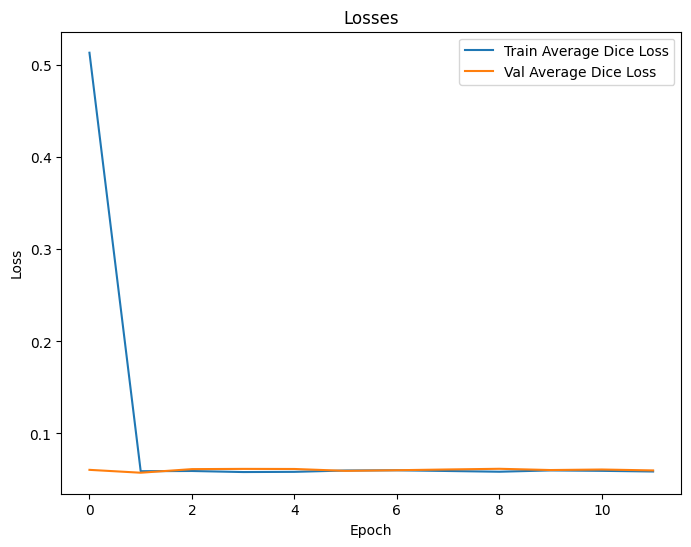

In [4]:
# history_path = os.path.join(snapshot_path, 'epoch_43_history.npz')
history_path = 'results/epoch_11_history.npz'
history = np.load(history_path)['history']
print(history)

history_np = np.array(history)

plt.figure(figsize=(8, 6))
plt.plot(history_np[:, 0], label="Train Average Dice Loss")
plt.plot(history_np[:, 1], label="Val Average Dice Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.show()

[[0.90177009 0.10027585]
 [0.10141693 0.09970253]
 [0.1016077  0.100201  ]
 [0.10148719 0.10040139]
 [0.10192706 0.09949003]
 [0.10181014 0.10006456]
 [0.1012303  0.10010207]
 [0.10205557 0.10044769]
 [0.10178995 0.10088688]
 [0.10176543 0.10066385]
 [0.10159929 0.10033837]
 [0.10128856 0.10075054]
 [0.10174329 0.09906639]
 [0.10142849 0.10059809]
 [0.10136719 0.10120034]
 [0.10184377 0.10027654]
 [0.10179969 0.10058897]
 [0.10166968 0.1012628 ]
 [0.10138406 0.09978949]
 [0.10164073 0.10015209]
 [0.10159533 0.10012683]
 [0.10173226 0.10100048]
 [0.1017615  0.10073848]
 [0.10187968 0.10128783]
 [0.10136683 0.10061105]
 [0.10111832 0.10042463]
 [0.10126748 0.10050148]
 [0.10159553 0.10043911]
 [0.10155803 0.09980222]
 [0.10138355 0.10013831]
 [0.1014337  0.09937841]
 [0.10216742 0.0998526 ]
 [0.10176106 0.10023948]
 [0.10194243 0.10060111]
 [0.10193    0.10080018]
 [0.10149563 0.10093817]
 [0.10139224 0.09996272]
 [0.10142951 0.10041298]
 [0.10191859 0.10051358]
 [0.10187131 0.10047586]


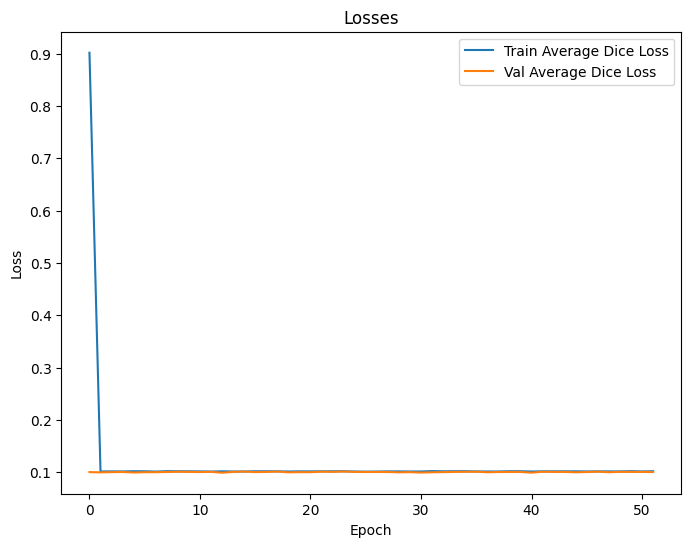

In [2]:
# history_path = os.path.join(snapshot_path, 'epoch_43_history.npz')
history_path = 'snapshots/4_8/epoch_51_history_0408-1831.npz'
history = np.load(history_path)['history']
print(history)

history_np = np.array(history)

plt.figure(figsize=(8, 6))
plt.plot(history_np[:, 0], label="Train Average Dice Loss")
plt.plot(history_np[:, 1], label="Val Average Dice Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.show()

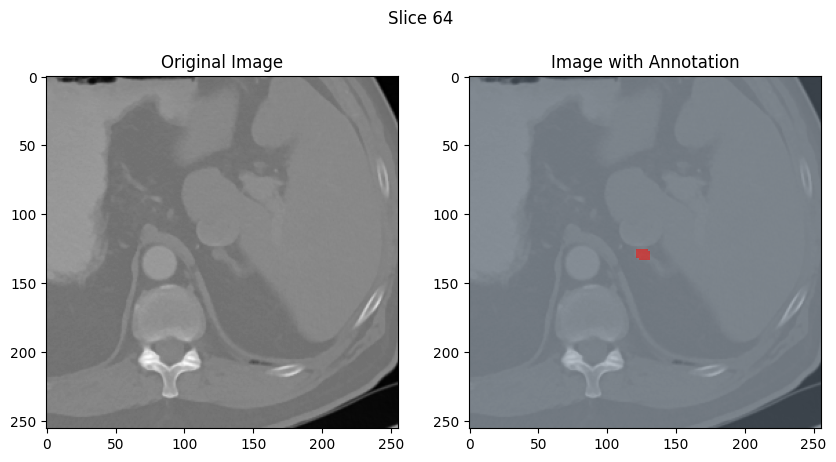

In [7]:
import nibabel as nib
from nilearn import plotting
import gzip
import zipfile
import io
import matplotlib.pyplot as plt
import matplotlib.colors
from skimage.transform import rotate
import numpy as np

image_path = 'datasets/ULS23_deepLesion3D/images/000028_02_01_059_lesion_01.nii.gz'
image_nifti = nib.load(image_path)
image_array = image_nifti.get_fdata()

label_path = 'datasets/ULS23_deepLesion3D/labels/000028_02_01_059_lesion_01.nii.gz'
label_nifti = nib.load(label_path)
label_array = label_nifti.get_fdata()

# Define a nice binary colormap
cmap = matplotlib.colors.ListedColormap(['slategray', 'red'])

# Visualize a single annotated slice (adjust the slice number as needed)
slice_number = 64
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.rot90(image_array[:, :, slice_number]), cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(np.rot90(image_array[:, :, slice_number]), cmap='gray')
axes[1].imshow(np.rot90(label_array[:, :, slice_number]), cmap=cmap, alpha=0.5, interpolation='none')  # Overlay annotations
axes[1].set_title('Image with Annotation')
plt.suptitle(f'Slice {slice_number}')
plt.show()

In [13]:
from models.uken import UNet3DWithKEM
model = UNet3DWithKEM(base_n_filter=16, ncodes=12)
model = nn.DataParallel(model)
model.load_state_dict(torch.load('snapshots/4_8/epoch_51_best_0408-1831.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [19]:
image = np.expand_dims(np.moveaxis(np.squeeze(image_array), 2, 0), axis=(0, 1))
image = torch.tensor(image, dtype=torch.float32)
output = model(image)

In [29]:
output_array = np.moveaxis(np.squeeze(output.detach().numpy(), (0, 1)), 0, 2)
output_array.shape

(256, 256, 128)

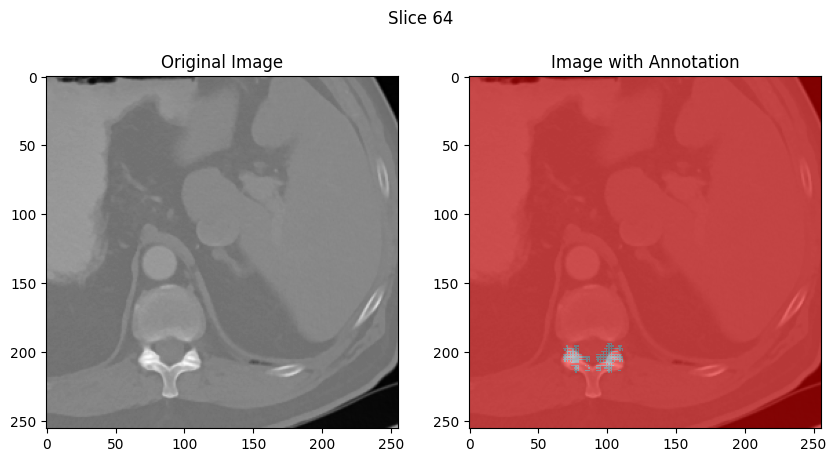

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.rot90(image_array[:, :, slice_number]), cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(np.rot90(image_array[:, :, slice_number]), cmap='gray')
axes[1].imshow(np.rot90(output_array[:, :, slice_number]), cmap=cmap, alpha=0.5, interpolation='none')  # Overlay annotations
axes[1].set_title('Image with Annotation')
plt.suptitle(f'Slice {slice_number}')
plt.show()